In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import os
from collections import Counter

In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
p_in="/Users/vorsi/Dropbox/moby-data_not_shared/SMALL_data/Inclusion illustrations/"

In [4]:
rel_files=[f for f in os.listdir(p_in) 
 if f.endswith(".csv")]

In [5]:
networks={}
genders={}
for f in sorted(rel_files):
    attr=("_").join(f.split("_")[:2])
    if 'gender' not in f:
        A=np.matrix(pd.read_csv(p_in+f).set_index('Unnamed: 0'))
        G = nx.from_numpy_matrix(A)
        networks[attr]=G
    else:
        genders[attr]=pd.read_csv(p_in+f)['gender'].replace(1,'male').replace(2,'female').to_dict()

In [6]:
genders.keys()==networks.keys()

True

In [7]:
def calc_net(G,G_df, game_id):
    res['assortativity']=assortativity
    res['game_id']=game_id
    return res

def join_gender_data(data, genders):
    data1=data.merge(genders[['developer_id', 'gender']], left_on='dev1', right_on='developer_id')
    data2=data1.merge(genders[['developer_id', 'gender']], left_on='dev2', right_on='developer_id')
    data3=data2.rename(columns={'gender_x':'dev1_gender',
                        'gender_y':'dev2_gender'})
    data4=data3[['dev1', 'dev2', 'weight','dev1_gender', 'dev2_gender' ]]
    return data4


def create_gender_con(row):
    if row['dev1_gender']=='male' and row['dev2_gender']=='male':
        return 'mm'
    elif row['dev1_gender']=='female' and row['dev2_gender']=='female':
        return 'ff'
    if row['dev1_gender']=='female' and row['dev2_gender']=='male' or row['dev1_gender']=='male' and row['dev2_gender']=='female':
        return 'mixed'
    
def prepare_data(g):
    df=nx.to_pandas_edgelist(g, source='dev1', target='dev2')
    node_genders=pd.DataFrame.from_dict(dict(g.nodes(data=True))).T
    node_genders['developer_id']=node_genders.index
    df2=join_gender_data(df, node_genders)
    df2['gender_con']=df2.apply(create_gender_con,1)
    return df2

def get_nodes(df):
    return list(set(df["dev1"]).union(set(df["dev2"])))


def calc_cross_calls(df):
    if 'mixed' in df['gender_con'].value_counts().index:
        return len(df[df['gender_con']=='mixed'])
    else:
        return 0

def get_unique_users(df, g_dict):
    u=pd.DataFrame(get_nodes(data)).set_index(0).join(pd.DataFrame(g_dict.items()).set_index(0), how='inner')
    return u

def calc_all_network_metric(df, node_genders_new, game_id):
    df2=join_gender_data(df, node_genders_new)
    df2['gender_con']=df2.apply(create_gender_con,1)
    cross_edge_ratio=calc_cross_calls(df2)
    ASS=nx.attribute_assortativity_coefficient(G, "gender")
    #all_genders_game=list(get_unique_users(data, g_dict)[1])
    c={}
    #EDGES
    try:
        c['n_males']=node_genders_new['gender'].value_counts()['male']
    except:
        c['n_males']=0
    try:
        c['n_females']=node_genders_new['gender'].value_counts()['female']
    except:
        c['n_females']=0
    c['assortativity']=ASS
    c['cross_edge_ratio']=cross_edge_ratio
    c["male_male"]=len(df2[df2['gender_con']=='mm'])
    c["female_female"]=len(df2[df2['gender_con']=='ff'])
    c["mixed"]=len(df2[df2['gender_con']=='mixed'])
    c["male_male_w"]=len(df2[df2['gender_con']=='mm'])
    c["female_female_w"]=len(df2[df2['gender_con']=='ff'])
    c["mixed_w"]=df2[df2['gender_con']=='mixed']['weight'].sum()
    c["num_edges"]=len(df2)
    c["num_Weighted_edges"]=df2['weight'].sum()
    c["Avg_Weight"]=df2['weight'].mean()
    male_coreN,female_coreN,male_peripheryN,female_peripheryN, num_core,num_periphery =coreness_gender(G, g_dict)
    c["male_coreN"]=male_coreN
    c["female_coreN"]=female_coreN
    c["male_peripheryN"]=male_peripheryN
    c["female_peripheryN"]=female_peripheryN
    c["num_core"]=num_core
    c["num_periphery"]=num_periphery
    c["Net_size"]=10
    c["Team_size"]=10
    c['gamie_id']=game_id
    return pd.DataFrame.from_dict(c, 'index').T

In [8]:
def coreness_gender(g2, g_dict_change):
    try:
        core_nodes=nx.distance_measures.center(g2)
        periphery_nodes=nx.distance_measures.periphery(g2)
        core_genders=[]
        per_genders=[]
        for cn in core_nodes:
            core_genders.append(g_dict_change[cn])
            res=dict(Counter(core_genders))
        for pn in periphery_nodes:
            per_genders.append(g_dict_change[pn])
            res2=dict(Counter(per_genders))
        return (res.get('male'),res.get('female'),res2.get('male'),res2.get('female'), len(core_nodes), len(periphery_nodes))
    except:
        Gcc = sorted(nx.connected_components(g2), key=len, reverse=True)
        giant = g2.subgraph(Gcc[0])
        core_nodes=nx.distance_measures.center(giant)
        periphery_nodes=nx.distance_measures.periphery(giant)
        core_genders=[]
        per_genders=[]
        for cn in core_nodes:
            core_genders.append(g_dict_change[cn])
            res=dict(Counter(core_genders))
        for pn in periphery_nodes:
            per_genders.append(g_dict_change[pn])
            res2=dict(Counter(per_genders))
        return (res.get('male'),res.get('female'),res2.get('male'),res2.get('female'), len(core_nodes), len(periphery_nodes))
        #except:
        #    return (np.nan,np.nan,np.nan,np.nan, np.nan, np.nan)

In [9]:
len(networks.keys())

8

In [10]:
def get_unique_net_gender(k,df):
    g=pd.DataFrame.from_dict(genders[k],'index').reset_index().rename(columns={'index':"developer_id"})
    df_=df.merge(g, left_on='dev1', right_on="developer_id").rename(columns={0:'gender1'}).merge(g, left_on='dev2', right_on="developer_id").rename(columns={0:'gender2'})
    d=df_[["dev1",'gender1']].append(df_[["dev2",'gender2']].rename(columns={"dev2":"dev1",
                                                                      "gender2":"gender1"})).drop_duplicates()
    return d.rename(columns={"dev1":'developer_id',
                            'gender1':"gender"})
    

In [11]:
res=pd.DataFrame()
for k in networks.keys():
    print(k)
    G=networks[k]
    g_dict=genders[k]
    nx.set_node_attributes(G, g_dict, 'gender')         
    df=nx.to_pandas_edgelist(G, source='dev1', target='dev2')
    node_genders2=get_unique_net_gender(k,df)
    r=calc_all_network_metric(df, node_genders2, k)
    r['network']=k
    r["female_new"]=Counter(g_dict.values())['female']
    r["male_new"]=Counter(g_dict.values())['male']
    res=res.append(r)

bonding_high
bonding_low
connecting_high
connecting_low
incorporating_high
incorporating_low
mixing_high
mixing_low


/Users/vorsi/opt/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:263: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


In [78]:
#res

In [14]:
res=res.replace(np.nan,0)

In [15]:
res

,n_males,n_females,assortativity,cross_edge_ratio,male_male,female_female,mixed,male_male_w,female_female_w,mixed_w,...,network,female_new,male_new,prop_women2,alex_het2,blau2,female_ratio_net2,female_coreness,female_coreness_log,weighted_cross_edges_ratio
0,6,4,-0.030303,8,7,2,8,7,2,64,...,bonding_high,4,6,0.4,0.673012,0.48,0.4,0.25,0.223144,0.097561
0,6,4,-0.030303,8,7,2,8,7,2,16,...,bonding_low,4,6,0.4,0.673012,0.48,0.4,0.25,0.223144,0.090909
0,6,4,-0.153846,4,11,0,4,11,0,8,...,connecting_high,4,6,0.4,0.673012,0.48,0.4,0.00,0.000000,0.133333
0,6,0,0.000000,0,11,0,0,11,0,0,...,connecting_low,4,6,0.4,0.673012,0.48,0.0,0.00,0.000000,0.000000
0,6,4,-0.214286,10,2,5,10,2,5,20,...,incorporating_high,4,6,0.4,0.673012,0.48,0.4,0.75,0.559616,0.294118
0,6,4,-0.133333,4,13,0,4,13,0,8,...,incorporating_low,4,6,0.4,0.673012,0.48,0.4,0.00,0.000000,0.117647
0,6,4,-0.619048,13,4,0,13,4,0,26,...,mixing_high,4,6,0.4,0.673012,0.48,0.4,0.25,0.223144,0.382353
0,6,4,1.000000,0,11,6,0,11,6,0,...,mixing_low,4,6,0.4,0.673012,0.48,0.4,0.00,0.000000,0.000000


In [16]:
def Blau_2(row):
    return 1-((row['prop_women2']**2)+((1-row['prop_women2'])**2))

def H_known_gender(row):
    mratio=1-row['prop_women2']
    m=mratio*np.log(mratio)
    f=(row['prop_women2']*np.log(row['prop_women2']))
    return -1*(m+f)

res['prop_women2']=res['female_new']/(res['female_new']+res['male_new'])
res['alex_het2']=res.apply(H_known_gender,1)
res['blau2']=res.apply(Blau_2,1)

res['female_ratio_net2']=res['n_females']/(res['n_females']+res['n_males'])
res['female_coreness']=(res['female_coreN']/res['female_new'])
res['female_coreness_log']=np.log(res['female_coreness'].replace(np.nan,0)+1)


res['weighted_cross_edges_ratio']=(res['mixed']/res['num_Weighted_edges'])
res['weighted_cross_edges_ratio_log']=np.log(res['weighted_cross_edges_ratio'].replace(np.nan,0)+1)
res['assortativity_rev']=(res['assortativity'])*-1
res['assortativity_rev_log']=np.log(res['assortativity_rev'].replace(np.nan,0)+1)


/Users/vorsi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
res=res.replace(- np.inf, np.nan)

In [18]:
res=res.set_index('network')

In [19]:
x = res[['prop_women2', 'alex_het2',
       'blau2', 'female_ratio_net2', 'female_coreness', 'female_coreness_log',
       'weighted_cross_edges_ratio', 'weighted_cross_edges_ratio_log',
       'assortativity_rev', 'assortativity_rev_log']].replace(np.nan,0).dropna().values #returns a numpy array


min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


df = pd.DataFrame(x_scaled, columns=['prop_women2', 'alex_het2',
       'blau2', 'female_ratio_net2', 'female_coreness', 'female_coreness_log',
       'weighted_cross_edges_ratio', 'weighted_cross_edges_ratio_log',
       'assortativity_rev', 'assortativity_rev_log'])


df['network']=res.index

res=res.join(df.set_index('network'), rsuffix='_z', how='left')

In [20]:
res['n_females']

network
bonding_high          4
bonding_low           4
connecting_high       4
connecting_low        0
incorporating_high    4
incorporating_low     4
mixing_high           4
mixing_low            4
Name: n_females, dtype: int64

In [22]:
p_in

'/Users/vorsi/Dropbox/moby-data_not_shared/SMALL_data/Inclusion illustrations/'

In [24]:
res[['prop_women2', 
     'alex_het2', 
     'blau2',
     'female_ratio_net2',
     "assortativity_rev_z",
     "weighted_cross_edges_ratio_z",
     "female_coreness_log_z"]].rename(columns={'prop_women2':"Female Ratio",
                                               'alex_het2': "Heterogenity",
                                                 'blau2': "Blau's Index", 
                                              'female_ratio_net2': "Connecting",
                                                 "assortativity_rev_z":"Mixing",
                                               "weighted_cross_edges_ratio_z":"Bonding",
                                            "female_coreness_log_z":'Incorporating'}).to_excel(p_in+"toy_networks_metrics.xlsx")

In [26]:
res[['prop_women2', 
     'alex_het2', 
     'blau2',
     'female_ratio_net2',
     "assortativity_rev_z",
     "weighted_cross_edges_ratio_z",
     "female_coreness_log_z"]].rename(columns={'prop_women2':"Female Ratio",
                                               'alex_het2': "Heterogenity",
                                                 'blau2': "Blau's Index", 
                                              'female_ratio_net2': "Connecting",
                                                 "assortativity_rev_z":"Mixing",
                                               "weighted_cross_edges_ratio_z":"Bonding",
                                            "female_coreness_log_z":'Incorporating'})

,Female Ratio,Heterogenity,Blau's Index,Connecting,Mixing,Bonding,Incorporating
network,,,,,,,
bonding_high,0.4,0.673012,0.48,0.4,0.636364,0.255159,0.398744
bonding_low,0.4,0.673012,0.48,0.4,0.636364,0.237762,0.398744
connecting_high,0.4,0.673012,0.48,0.4,0.712670,0.348718,0.000000
connecting_low,0.4,0.673012,0.48,0.0,0.617647,0.000000,0.000000
incorporating_high,0.4,0.673012,0.48,0.4,0.750000,0.769231,1.000000
incorporating_low,0.4,0.673012,0.48,0.4,0.700000,0.307692,0.000000
mixing_high,0.4,0.673012,0.48,0.4,1.000000,1.000000,0.398744
mixing_low,0.4,0.673012,0.48,0.4,0.000000,0.000000,0.000000


In [25]:
Inclusion illustrations/toy_networks_metrics.xlsx

'/Users/vorsi/Dropbox/moby-data_not_shared/SMALL_data/Inclusion illustrations/'

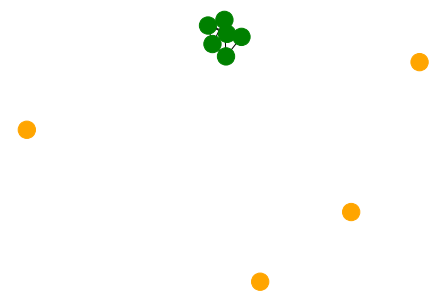

In [19]:
colors=[]
for node in G.nodes(data=True):
    if node[1]['gender']=='male':
        c='green'
    elif node[1]['gender']=='female':
        c='orange'
    else:
        c="grey"
    colors.append(c)
#pos=nx.spring_layout(G)
nx.draw(G, pos=pos,
        cmap = plt.get_cmap('jet'), 
        node_color = colors, 
        edge_color='black', 
        #width= [node[2]['weight']/4 for node in G.edges(data=True)],
        #node_size=[i/3 for i in dict(G.degree()).values()], 
        with_labels=False)
#plt.savefig('/Users/orsi/Dropbox/moby-data_not_shared/SMALL_data/FIGURES/'+f[:-3]+"coreness.pdf")
plt.show()